In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download kazanova/sentiment140

 79% 64.0M/80.9M [00:00<00:00, 78.0MB/s]
100% 80.9M/80.9M [00:00<00:00, 150MB/s] 


In [6]:
! unzip sentiment140.zip

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [7]:
#importing libraries

import pandas as pd
import numpy as np
import re
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score

In [8]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
cols = ['target','id','date','flag','user','text']
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1' ,names=cols)

In [10]:
df['target'].value_counts()

0    800000
4    800000
Name: target, dtype: int64

In [11]:
df = df.loc[795001:805000,:]
df

,target,id,date,flag,user,text
795001,0,2327193206,Thu Jun 25 08:02:16 PDT 2009,NO_QUERY,djcampos,Blah 5am still up daang I got deep problems
795002,0,2327193455,Thu Jun 25 08:02:17 PDT 2009,NO_QUERY,RKF,@jenspeedy I would suggest avoiding 360 Living...
795003,0,2327193641,Thu Jun 25 08:02:18 PDT 2009,NO_QUERY,AnaHertz,@alexbroun I didn't convince myself I was fat ...
795004,0,2327193806,Thu Jun 25 08:02:18 PDT 2009,NO_QUERY,yenafer,"@spotzle @jstarrh check on sunscreen, snacks, ..."
795005,0,2327193864,Thu Jun 25 08:02:19 PDT 2009,NO_QUERY,eppoponotumus,im sitting alone at TTE myself without my two ...
...,...,...,...,...,...,...
804996,4,1468599688,Tue Apr 07 02:39:04 PDT 2009,NO_QUERY,joscelinyeo,@ickleoriental hahahha.. U obviously don't hv ...
804997,4,1468599702,Tue Apr 07 02:39:04 PDT 2009,NO_QUERY,serengetisunset,"@juliekoh It's an internet term, but it's spil..."
804998,4,1468599765,Tue Apr 07 02:39:06 PDT 2009,NO_QUERY,broombeck,new day.... NEW TRACK!!!!
804999,4,1468599793,Tue Apr 07 02:39:07 PDT 2009,NO_QUERY,aptronym,@foodieguide Okay we need to have a competitio...


([<matplotlib.axis.XTick at 0x7f30a0dd5590>,
 [Text(0, 0, 'Negative'), Text(0, 0, 'Positive')])

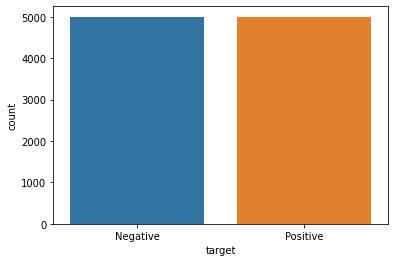

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(data=df,x='target')
plt.xticks(ticks=[0,1],labels=['Negative','Positive'])

In [13]:
df.head()

,target,id,date,flag,user,text
795001,0,2327193206,Thu Jun 25 08:02:16 PDT 2009,NO_QUERY,djcampos,Blah 5am still up daang I got deep problems
795002,0,2327193455,Thu Jun 25 08:02:17 PDT 2009,NO_QUERY,RKF,@jenspeedy I would suggest avoiding 360 Living...
795003,0,2327193641,Thu Jun 25 08:02:18 PDT 2009,NO_QUERY,AnaHertz,@alexbroun I didn't convince myself I was fat ...
795004,0,2327193806,Thu Jun 25 08:02:18 PDT 2009,NO_QUERY,yenafer,"@spotzle @jstarrh check on sunscreen, snacks, ..."
795005,0,2327193864,Thu Jun 25 08:02:19 PDT 2009,NO_QUERY,eppoponotumus,im sitting alone at TTE myself without my two ...


In [14]:
df.shape

(10000, 6)

In [15]:
df.isnull().any()

target    False
id        False
date      False
flag      False
user      False
text      False
dtype: bool

In [16]:
df = df[['target','text']]
df.head()

,target,text
795001,0,Blah 5am still up daang I got deep problems
795002,0,@jenspeedy I would suggest avoiding 360 Living...
795003,0,@alexbroun I didn't convince myself I was fat ...
795004,0,"@spotzle @jstarrh check on sunscreen, snacks, ..."
795005,0,im sitting alone at TTE myself without my two ...


In [17]:
nltk.download('wordnet')
def clean_text(text):
    #casing
    text = text.lower()

    #noise removal
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
        
    emoji = re.compile("["
                       u"\U0001F600-\U0001FFFF"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       "]+", flags=re.UNICODE)
    text = emoji.sub(r'', text)
        
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
        
    text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags = re.MULTILINE)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r'\@\w+|\@', "", text)
    text = re.sub('[0-9]+', '', text)

    #tokenization
    tokens = word_tokenize(text)

    #Stopwords removal
    tokens = [t for t in tokens if t not in stopwords] #remove stopwords
    
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in tokens]
        
    return " ".join(lemma_words).lower()

df['text'] = [clean_text(text) for text in df['text']]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
df.head()

,target,text
795001,0,blah still daang got deep problems
795002,0,jenspeedy would suggest avoiding living goodne...
795003,0,alexbroun didnt convince fat ugly someone else...
795004,0,spotzle jstarrh check sunscreen snacks towels ...
795005,0,im sitting alone tte without two michigan sist...


In [19]:
df.isnull().any()

target    False
text      False
dtype: bool

In [27]:
X = df['text']
Y = df['target']

In [30]:
X

795001                   blah still daang got deep problems
795002    jenspeedy would suggest avoiding living goodne...
795003    alexbroun didnt convince fat ugly someone else...
795004    spotzle jstarrh check sunscreen snacks towels ...
795005    im sitting alone tte without two michigan sist...
                                ...                        
804996    ickleoriental hahahha u obviously hv one maybe...
804997    juliekoh internet term spilled common use real...
804998                                    new day new track
804999    foodieguide okay need competition see whether ...
805000    perfectelement noooooooo wish saw advertised l...
Name: text, Length: 10000, dtype: object

In [93]:
from sklearn.feature_extraction.text import CountVectorizer
countvector = CountVectorizer()
X = countvector.fit_transform(df['text'])
X

<10000x17984 sparse matrix of type '<class 'numpy.int64'>'
	with 72266 stored elements in Compressed Sparse Row format>

In [49]:
X[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [50]:
countvector.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aaa',
 'aaaa',
 'aaaaages',
 'aaaaahhh',
 'aaaaahhhh',
 'aaaall',
 'aaaand',
 'aaah',
 'aaajaayradd',
 'aaargh',
 'aaarrrrgghhhh',
 'aaaww',
 'aadm',
 'aahoogendoorn',
 'aaminahh',
 'aampj',
 'aargh',
 'aaronfilmmaker',
 'aaronmiciah',
 'aaronshale',
 'aaru',
 'abacab',
 'abay',
 'abby',
 'abbyjeanne',
 'abc',
 'abcdefglynis',
 'abcessed',
 'abdomen',
 'abegruber',
 'aber',
 'aberdeenfc',
 'aberystwytharts',
 'abhisheknagar',
 'abhishektiwari',
 'abhishekupadhya',
 'abigail',
 'abigaillovesyou',
 'abikent',
 'ability',
 'abipips',
 'abis',
 'abisignorelli',
 'abit',
 'able',
 'ablt',
 'abolished',
 'aboogie',
 'abroad',
 'absolute',
 'absolutely',
 'absolutley',
 'absorb',
 'absorbing',
 'abt',
 'abused',
 'ac',
 'acabo',
 'academy',
 'accent',
 'accept',
 'accepted',
 'access',
 'accessquot',
 'accident',
 'accidentally',
 'accidents',
 'accom',
 'accomodation',
 'accompanied',
 'accompanying',
 'accomplished',
 'accordance',
 'according',
 'account',
 'accountant',
 'accountants',


In [51]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

<h1><b>MultinomialNB</b></h1>

In [52]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
mnb = MultinomialNB()
y_pred_mnb = mnb.fit(x_train, y_train).predict(x_test)
print('Naive-Bayes Accuracy :',accuracy_score(y_test,y_pred_mnb)*100, '%')

Naive-Bayes Accuracy : 76.9 %


In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_mnb)

array([[787, 200],
       [262, 751]])

In [54]:
from sklearn.metrics import precision_score
precision_mnb = precision_score(y_test,y_pred_mnb,average = None)
print(precision_mnb)

[0.75023832 0.78969506]


In [55]:
from sklearn.metrics import recall_score
recall_mnb = recall_score(y_test,y_pred_mnb, average=None)
print(recall_mnb)

[0.79736575 0.74136229]


In [56]:
from sklearn.metrics import f1_score
f1_score_mnb = f1_score(y_test,y_pred_mnb,average=None)
print(f1_score_mnb)

[0.77308448 0.76476578]


In [57]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_mnb))

              precision    recall  f1-score   support

           0       0.75      0.80      0.77       987
           4       0.79      0.74      0.76      1013

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000



<h1><b>ComplementNB</b></h1>

In [58]:
from sklearn.naive_bayes import ComplementNB
cnb = ComplementNB()
y_pred_cnb = cnb.fit(x_train, y_train).predict(x_test)
print('Naive-Bayes Accuracy :',accuracy_score(y_test,y_pred_cnb)*100, '%')

Naive-Bayes Accuracy : 76.9 %


In [59]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_cnb)

array([[787, 200],
       [262, 751]])

In [60]:
from sklearn.metrics import precision_score
precision_cnb = precision_score(y_test,y_pred_cnb,average = None)
print(precision_cnb)

[0.75023832 0.78969506]


In [61]:
from sklearn.metrics import recall_score
recall_cnb = recall_score(y_test,y_pred_cnb, average=None)
print(recall_cnb)

[0.79736575 0.74136229]


In [62]:
from sklearn.metrics import f1_score
f1_score_cnb = f1_score(y_test,y_pred_cnb,average=None)
print(f1_score_cnb)

[0.77308448 0.76476578]


In [63]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_cnb))

              precision    recall  f1-score   support

           0       0.75      0.80      0.77       987
           4       0.79      0.74      0.76      1013

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000



<h1><b>Logistic Regression</b></h1>

In [64]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000)
y_pred_lr = lr.fit(x_train, y_train).predict(x_test)
print('Linear Regression :',accuracy_score(y_test,y_pred_lr)*100, '%')

Linear Regression : 75.55 %


In [65]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_lr)

array([[734, 253],
       [236, 777]])

In [66]:
from sklearn.metrics import precision_score
precision_lr = precision_score(y_test,y_pred_lr,average = None)
print(precision_lr)

[0.75670103 0.75436893]


In [67]:
from sklearn.metrics import recall_score
recall_lr = recall_score(y_test,y_pred_cnb, average=None)
print(recall_lr)

[0.79736575 0.74136229]


In [68]:
from sklearn.metrics import f1_score
f1_score_lr = f1_score(y_test,y_pred_lr,average=None)
print(f1_score_lr)

[0.75012775 0.76064611]


In [69]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.76      0.74      0.75       987
           4       0.75      0.77      0.76      1013

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000



<h1><b>Graphs</b></h1>

Positive Sentiment

Text(0, 0.5, 'Percentage')

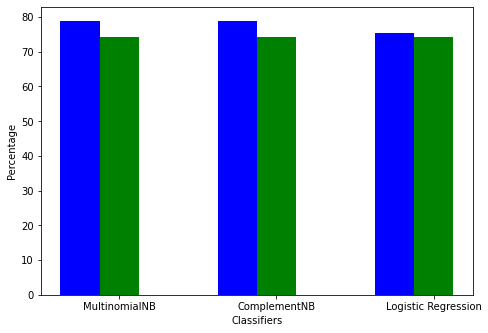

In [70]:
import matplotlib.pyplot as plt
import numpy as np

data = [[precision_mnb[1] * 100 , precision_cnb[1] * 100, precision_lr[1] * 100],
        [recall_mnb[1] * 100, recall_cnb[1] * 100,  recall_lr[1] * 100]]

X = np.arange(3)
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.bar(X+0.00, data[0], color='b', width=0.25)
ax.bar(X+0.25, data[1], color='g', width=0.25)
plt.xticks([r + 0.25 for r in range(len(data[1]))], ['MultinomialNB', 'ComplementNB', 'Logistic Regression'])

plt.xlabel('Classifiers')
plt.ylabel('Percentage')

#Blue is precision, Green is recall

Negative Sentiment

Text(0, 0.5, 'Percentage')

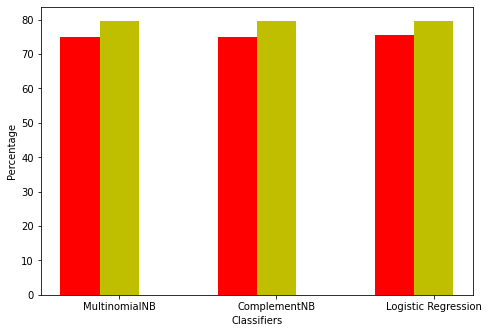

In [71]:
data = [[precision_mnb[0] * 100 , precision_cnb[0] * 100, precision_lr[0] * 100],
        [recall_mnb[0] * 100, recall_cnb[0] * 100,  recall_lr[0] * 100]]

X = np.arange(3)
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.bar(X+0.00, data[0], color='r', width=0.25, label='Precision')
ax.bar(X+0.25, data[1], color='y', width=0.25, label='Recall')
plt.xticks([r + 0.25 for r in range(len(data[1]))], ['MultinomialNB', 'ComplementNB', 'Logistic Regression'])

plt.xlabel('Classifiers')
plt.ylabel('Percentage')

So, here we can see that when precision increases, recall decreases.

<h2><b>F1 score</b></h2>

F1 score is the harmonic progression between precision and recall.

F1 score = (2 x Precision x Recall)/(Precision + Recall)

Text(0, 0.5, 'Percentage')

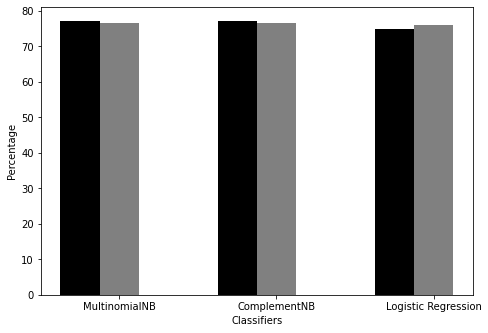

In [72]:
data = [[f1_score_mnb[0] * 100 , f1_score_cnb[0] * 100, f1_score_lr[0] * 100],
        [f1_score_mnb[1] * 100, f1_score_cnb[1] * 100,  f1_score_lr[1] * 100]]

X = np.arange(3)
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.bar(X+0.00, data[0], color='black', width=0.25, label='Negative Sentiment')
ax.bar(X+0.25, data[1], color='grey', width=0.25, label='Positive Sentiment')
plt.xticks([r + 0.25 for r in range(len(data[1]))], ['MultinomialNB', 'ComplementNB', 'Logistic Regression'])

plt.xlabel('Classifiers')
plt.ylabel('Percentage')

<h1><b>Testing with sentences</b></h1>

In [104]:
a = ['i like it']
a = countvector.transform(a)
print(a[0].toarray())
prediction = mnb.fit(x_train,y_train).predict(a)
prediction

[[0 0 0 ... 0 0 0]]


array([4])

In [105]:
a = ['i dislike it']
a = countvector.transform(a)
print(a[0].toarray())
prediction = mnb.fit(x_train,y_train).predict(a)
prediction

[[0 0 0 ... 0 0 0]]


array([0])